In [1]:
# Copyright (c) 2023, ISCS, Wenjie Zhang.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from __future__ import absolute_import, division, print_function, unicode_literals

import argparse

# miscellaneous
import builtins
import datetime
import json
import sys
import time

# onnx
# The onnx import causes deprecation warnings every time workers
# are spawned during testing. So, we filter out those warnings.
import warnings

# numpy
import numpy as np
import sklearn.metrics

# pytorch
import torch
import torch.nn as nn

from dsmeasure.core.abstract_operator import AbstractOperatorConfig, AbstractOperator
from dsmeasure.common_operators.op_common import OpStaticComputational, OpStaticNonComputational
from dsmeasure.common_operators.op_config import OperatorComputationalConfig, OperatorNonComputationalConfig, OperatorCustomConfig
from dsmeasure.core.operator_manager import OperatorManager
from dsmeasure.core.device_manager import DeviceManager
from dsmeasure.device.gpu import DeviceCUDAConfig
from dsmeasure.device.pcie4 import DevicePCIE4, DevicePCIEConfig
from models.transformer_simplify import UnaryLayer, BinaryLayer, CudaMalloc, AllReduceLayer, CoreAttentionTPCRParallel, FeedForwardLayerGPT, TransformerBlockGPT, GPT2Model

from dsmeasure.core.engine import CostEngine

In [2]:
gpt2_emulator_model = GPT2Model(config=OperatorCustomConfig(op_name="gpt2_emulator_model"),
    compute_time_embedding = 4000,
    compute_time_embedding_backward = 0,

    compute_time_att_linear_qkv = 490,
    compute_time_att_matmul_kq = 214, 
    compute_time_att_sm = 163,
    compute_time_att_attention_dropout = 286,
    compute_time_att_matmul_v = 191,
    compute_time_att_linear = 146,
    compute_time_att_allreduce = 2200,
    compute_time_att_dropout = 140,

    compute_time_att_linear_qkv_backward = 340,
    compute_time_att_matmul_kq_backward = 531,
    compute_time_att_sm_backward = 212,
    compute_time_att_attention_dropout_backward = 248,
    compute_time_att_matmul_v_backward = 360,
    compute_time_att_linear_backward = 250,
    compute_time_att_dropout_backward = 155,
    
    compute_time_ffn_layer1 = 512,
    compute_time_ffn_gelu = 428,
    compute_time_ffn_layer2 = 483,
    compute_time_ffn_allreduce = 2200,
    compute_time_ffn_dropout = 75,
    
    compute_time_ffn_layer1_backward = 442,
    compute_time_ffn_gelu_backward = 210,
    compute_time_ffn_layer2_backward = 100,
    compute_time_ffn_dropout_backward = 102,

    compute_time_layernorm_1 = 67,
    compute_time_layernorm_2 = 67,
    compute_time_layernorm_1_backward  = 236,
    compute_time_layernorm_2_backward = 236,
    
    compute_time_residual_add_1 = 67,
    compute_time_residual_add_2 = 67,
    compute_time_residual_add_1_backward = 10,
    compute_time_residual_add_2_backward = 10,
    
    compute_time_layernorm_final = 67,
    compute_time_layernorm_final_backward = 66,

    batch_size = 8,
    seq_len = 1024,
    head_num = 16,
    head_hidden_size = 112,
    hidden_size = 1792,
    vocab_size = 25216,
    tensor_parallel = 2,
    precision = 2,
    transformer_layers = 32
    )

In [3]:
OperatorManager().register(gpt2_emulator_model)
DeviceManager().register(DeviceCUDAConfig(memory_max_capacity=40000, memory_limit_capacity=40000))
DeviceManager().register(DevicePCIEConfig())

(65, <dsmeasure.device.pcie4.DevicePCIE4 at 0x7f9a76cdb0a0>)

In [4]:
CostEngine().evaluation(50, [gpt2_emulator_model._config.op_uid])

<operator- 66, output_malloc_embedding_29360128>
<operator- 67, unary_op_embedding>
<operator- 70, output_malloc_transformer_layernorm_1_29360128>
<operator- 72, unary_op_transformer_layernorm_1>
<operator- 77, output_malloc_attention_linear_qkv_9633792>
<operator- 80, unary_op_attention_linear_qkv>
<operator- 90, output_malloc_attention_matmul_kq_134217728>
<operator- 96, binary_op_attention_matmul_kq>
<operator-109, output_malloc_attention_softmax_134217728>
<operator-116, unary_op_attention_softmax>
<operator-133, output_malloc_attention_dropout_201326592>
<operator-143, unary_op_attention_dropout>
<operator- 91, output_malloc_attention_matmul_v_14680064>
<operator- 97, binary_op_attention_matmul_v>
<operator-110, output_malloc_attention_linear_0>
<operator-117, unary_op_attention_linear>
<operator-134, ar_op_attention_allreduce>
<operator-152, output_malloc_output_dropout_29360128>
<operator-162, unary_op_output_dropout>
<operator- 71, output_malloc_transformer_residual_add_1_29360

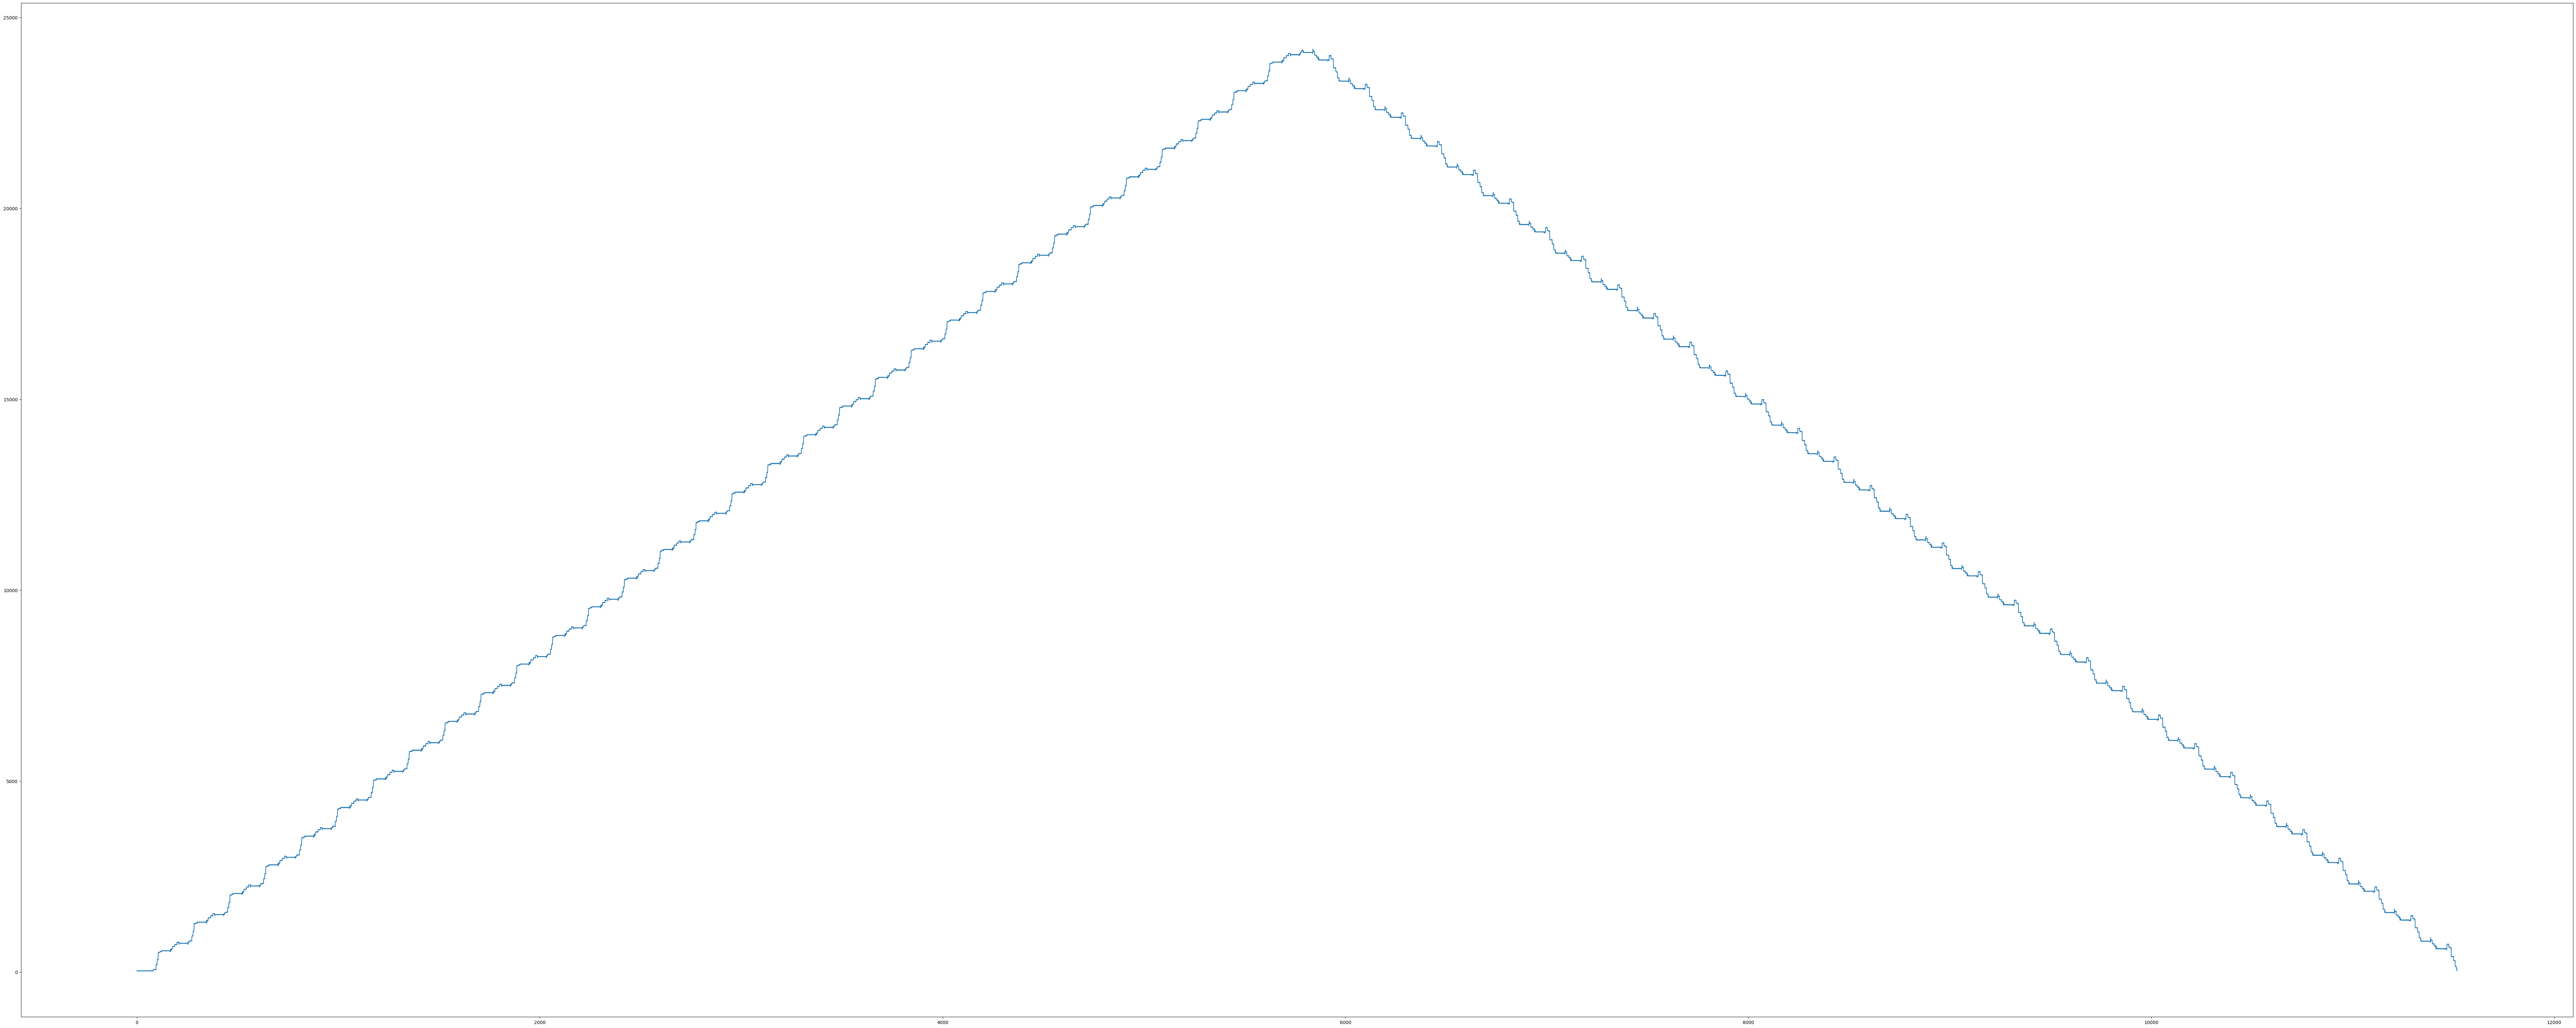

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(100,40))
plt.plot(list(range(len(CostEngine().cuda_memory_trace))), CostEngine().cuda_memory_trace, '.-', markersize=1)